In [1]:
import json
import datetime, time
import pytz
import re
import pandas as pd
import numpy as np
from sklearn import svm
from sklearn.metrics import accuracy_score, roc_curve, precision_score, recall_score
from sklearn.metrics import classification_report
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from  sklearn.model_selection import train_test_split
import scikitplot as skplt
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.ensemble import RandomForestClassifier

<b> Reading in Tweets from region(Washington, Massachusetts) specific files. </b>

In [2]:
f1 = open('data/en_washington.json', 'r')
f2 = open('data/en_masachusetts.json', 'r')

en_wa_tweets = []
en_ma_tweets = []

doc1 = json.load(f1)
for i in range(0, len(doc1)):
        en_wa_tweets.append(doc1[i])

doc2 = json.load(f2)
for i in range(0, len(doc2)):
        en_ma_tweets.append(doc2[i])

In [3]:
wa_df = pd.DataFrame(en_wa_tweets)
ma_df = pd.DataFrame(en_ma_tweets)

In [4]:
wa_df['location'] = 0
ma_df['location'] = 1

In [5]:
data = wa_df.append(ma_df)
data = data[['text','location']]

<b>Converting data frame into a matrix and splitting test and training data</b>

In [6]:
def preprocess_data(data):
    non_url = re.sub(r"http\S+", "", data)
    letters_only = re.sub("[^a-zA-Z]", " ", non_url)
    words = letters_only.split()
    ps = PorterStemmer()
    words = [ps.stem(w).lower() for w in words if not w.lower() in stopwords.words('english')]
    return(" ".join( words ))

In [7]:
n_data = data.as_matrix()

In [8]:
n_data[:,0][2]

u'Cutest little Seahawks fan yet! #naturalhairbaby #naturalhair  #superbowl #Seattle #Seahawks http://t.co/MGTjfMPqVy'

In [9]:
pre_data = np.copy(n_data)
for i in range(0, len(pre_data)):
    pre_data[i, 0] = preprocess_data(pre_data[i, 0])

In [10]:
X_train, X_test, y_train, y_test = train_test_split(pre_data[:, 0], pre_data[:, 1], test_size=0.20, random_state=42)

<b>Representing data as a TF-IDF matrix</b>

In [11]:
vectorizer = CountVectorizer(min_df = 2)
tfidf_transformer = TfidfTransformer()

In [12]:
vec_train_x = vectorizer.fit_transform(X_train)
tfidf_train_x = tfidf_transformer.fit_transform(vec_train_x)

In [13]:
vec_test_x = vectorizer.transform(X_test)
tfidf_test_x = tfidf_transformer.transform(vec_test_x)

In [14]:
nmf_model = NMF(n_components=50, init='random', random_state=0)

In [15]:
train_x = nmf_model.fit_transform(tfidf_train_x)

In [16]:
test_x = nmf_model.transform(tfidf_test_x)

<h2>Applying classification Models</h2>

<h3> SVM Hard Margin Classifier</h3>

In [17]:
classifier_hard = svm.SVC(C=1000, probability=True, kernel='linear')
classifier_hard.fit(train_x, y_train.astype(int))

SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [18]:
y_predict_hard = classifier_hard.predict(test_x)
y_predict_hard_prob = classifier_hard.predict_proba(test_x)

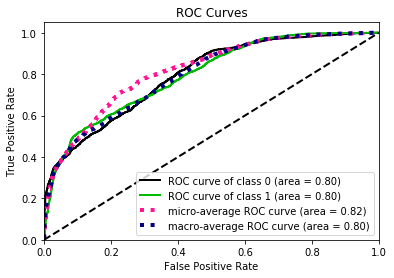

In [19]:
skplt.metrics.plot_roc_curve(y_test.astype(int), y_predict_hard_prob)
plt.show()

In [20]:
print(confusion_matrix(y_test.astype(int), y_predict_hard))

[[4215  304]
 [1672 1203]]


In [21]:
print("Accuracy : ", accuracy_score(y_test.astype(int), y_predict_hard))
print("Precision : ",precision_score(y_test.astype(int), y_predict_hard))
print("Recall : ",recall_score(y_test.astype(int), y_predict_hard))

('Accuracy : ', 0.73275628888287803)
('Precision : ', 0.79827471798274718)
('Recall : ', 0.41843478260869565)


In [22]:
print(classification_report(y_test.astype(int), y_predict_hard, target_names=['Washington', 'Masachusetts']))

              precision    recall  f1-score   support

  Washington       0.72      0.93      0.81      4519
Masachusetts       0.80      0.42      0.55      2875

 avg / total       0.75      0.73      0.71      7394



<h3> SVM Soft Margin Classifier</h3>

In [23]:
classifier_soft = svm.SVC(C=0.001, probability=True, kernel='linear')
classifier_soft.fit(train_x, y_train.astype(int))

SVC(C=0.001, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [24]:
y_predict_soft = classifier_soft.predict(test_x)
y_predict_soft_prob = classifier_soft.predict_proba(test_x)

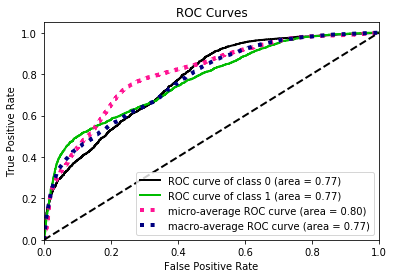

In [25]:
skplt.metrics.plot_roc_curve(y_test.astype(int), y_predict_soft_prob)
plt.show()

In [26]:
print(confusion_matrix(y_test.astype(int), y_predict_soft))

[[4519    0]
 [2875    0]]


In [27]:
print("Accuracy : ", accuracy_score(y_test.astype(int), y_predict_soft))
print("Precision : ",precision_score(y_test.astype(int), y_predict_soft))
print("Recall : ",recall_score(y_test.astype(int), y_predict_soft))

('Accuracy : ', 0.61117121990803358)
('Precision : ', 0.0)
('Recall : ', 0.0)


/Users/konarkjs/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [28]:
print(classification_report(y_test.astype(int), y_predict_soft, target_names=['Washington', 'Masachusetts']))

              precision    recall  f1-score   support

  Washington       0.61      1.00      0.76      4519
Masachusetts       0.00      0.00      0.00      2875

 avg / total       0.37      0.61      0.46      7394



/Users/konarkjs/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


<h3>Logistic Regression with L2 regularization</h3>

In [29]:
logistic_clf = LogisticRegression(penalty='l2', C=1000)
logistic_clf.fit(train_x, y_train.astype(int))

LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [30]:
y_predict = logistic_clf.predict(test_x)
y_predict_prob = logistic_clf.predict_proba(test_x)

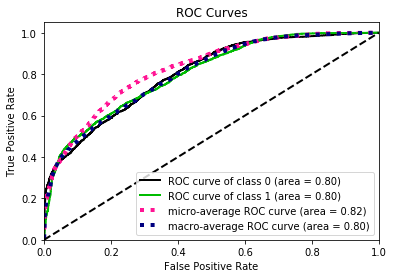

[[4274  245]
 [1663 1212]]
('Accuracy : ', 0.74195293481200975)
('Precision : ', 0.8318462594371997)
('Recall : ', 0.42156521739130437)
              precision    recall  f1-score   support

  Washington       0.72      0.95      0.82      4519
Masachusetts       0.83      0.42      0.56      2875

 avg / total       0.76      0.74      0.72      7394



In [31]:
skplt.metrics.plot_roc_curve(y_test.astype(int), y_predict_prob)
plt.show()
print(confusion_matrix(y_test.astype(int), y_predict))
print("Accuracy : ", accuracy_score(y_test.astype(int), y_predict))
print("Precision : ",precision_score(y_test.astype(int), y_predict))
print("Recall : ",recall_score(y_test.astype(int), y_predict))

print(classification_report(y_test.astype(int), y_predict, target_names=['Washington', 'Masachusetts']))

<h3>Logistic Regression with L2 regularization - Without dim reduction</h3>

In [32]:
logistic_clf = LogisticRegression(penalty='l2', C=1000)
logistic_clf.fit(tfidf_train_x, y_train.astype(int))

LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [33]:
y_predict = logistic_clf.predict(tfidf_test_x)
y_predict_prob = logistic_clf.predict_proba(tfidf_test_x)

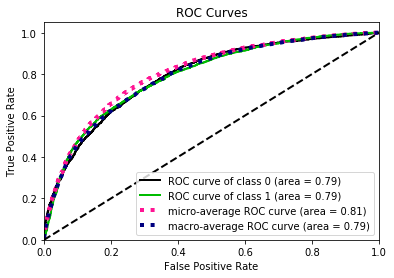

[[3630  889]
 [1076 1799]]
('Accuracy : ', 0.73424398160670812)
('Precision : ', 0.66927083333333337)
('Recall : ', 0.62573913043478258)
              precision    recall  f1-score   support

  Washington       0.77      0.80      0.79      4519
Masachusetts       0.67      0.63      0.65      2875

 avg / total       0.73      0.73      0.73      7394



In [34]:
skplt.metrics.plot_roc_curve(y_test.astype(int), y_predict_prob)
plt.show()
print(confusion_matrix(y_test.astype(int), y_predict))
print("Accuracy : ", accuracy_score(y_test.astype(int), y_predict))
print("Precision : ",precision_score(y_test.astype(int), y_predict))
print("Recall : ",recall_score(y_test.astype(int), y_predict))

print(classification_report(y_test.astype(int), y_predict, target_names=['Washington', 'Masachusetts']))

<h3>Logistic Regression without regularization</h3>

In [35]:
logistic_clf = LogisticRegression(penalty='l2', C=1e10)
logistic_clf.fit(train_x, y_train.astype(int))

LogisticRegression(C=10000000000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [36]:
y_predict = logistic_clf.predict(test_x)
y_predict_prob = logistic_clf.predict_proba(test_x)

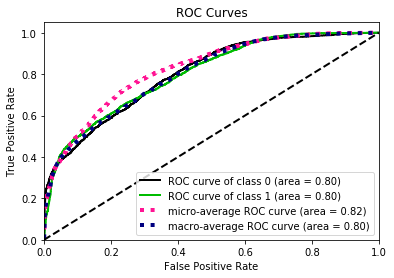

[[4274  245]
 [1662 1213]]
('Accuracy : ', 0.74208817960508522)
('Precision : ', 0.83196159122085045)
('Recall : ', 0.42191304347826086)
              precision    recall  f1-score   support

  Washington       0.72      0.95      0.82      4519
Masachussets       0.83      0.42      0.56      2875

 avg / total       0.76      0.74      0.72      7394



In [37]:
skplt.metrics.plot_roc_curve(y_test.astype(int), y_predict_prob)
plt.show()
print(confusion_matrix(y_test.astype(int), y_predict))
print("Accuracy : ", accuracy_score(y_test.astype(int), y_predict))
print("Precision : ",precision_score(y_test.astype(int), y_predict))
print("Recall : ",recall_score(y_test.astype(int), y_predict))

print(classification_report(y_test.astype(int), y_predict, target_names=['Washington', 'Masachussets']))

<h3>Logistic Regression with L1 regularization</h3>

In [38]:
logistic_clf = LogisticRegression(penalty='l1', C=1000)
logistic_clf.fit(train_x, y_train.astype(int))

LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [39]:
y_predict = logistic_clf.predict(test_x)
y_predict_prob = logistic_clf.predict_proba(test_x)

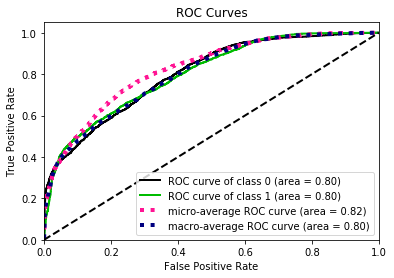

[[4274  245]
 [1661 1214]]
('Accuracy : ', 0.74222342439816069)
('Precision : ', 0.83207676490747084)
('Recall : ', 0.42226086956521741)
              precision    recall  f1-score   support

  Washington       0.72      0.95      0.82      4519
Masachussets       0.83      0.42      0.56      2875

 avg / total       0.76      0.74      0.72      7394



In [40]:
skplt.metrics.plot_roc_curve(y_test.astype(int), y_predict_prob)
plt.show()
print(confusion_matrix(y_test.astype(int), y_predict))
print("Accuracy : ", accuracy_score(y_test.astype(int), y_predict))
print("Precision : ",precision_score(y_test.astype(int), y_predict))
print("Recall : ",recall_score(y_test.astype(int), y_predict))

print(classification_report(y_test.astype(int), y_predict, target_names=['Washington', 'Masachussets']))

<h3>Random Forest Classifier</h3>

In [41]:
rforest_clf = RandomForestClassifier(n_estimators = 150)
rforest_clf.fit(train_x, y_train.astype(int))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [42]:
y_predict = rforest_clf.predict(test_x)
y_predict_prob = rforest_clf.predict_proba(test_x)

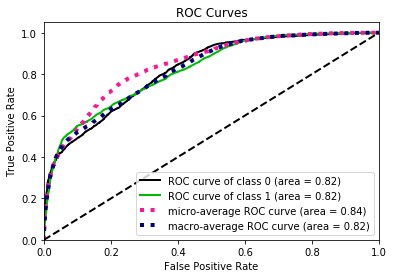

[[4111  408]
 [1339 1536]]
('Accuracy : ', 0.7637273464971599)
('Precision : ', 0.79012345679012341)
('Recall : ', 0.53426086956521734)
              precision    recall  f1-score   support

  Washington       0.75      0.91      0.82      4519
Masachussets       0.79      0.53      0.64      2875

 avg / total       0.77      0.76      0.75      7394



In [43]:
skplt.metrics.plot_roc_curve(y_test.astype(int), y_predict_prob)
plt.show()
print(confusion_matrix(y_test.astype(int), y_predict))
print("Accuracy : ", accuracy_score(y_test.astype(int), y_predict))
print("Precision : ",precision_score(y_test.astype(int), y_predict))
print("Recall : ",recall_score(y_test.astype(int), y_predict))

print(classification_report(y_test.astype(int), y_predict, target_names=['Washington', 'Masachussets']))